In [26]:
%load_ext autoreload
%autoreload 2

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import requests
from PIL import Image
from utils.utils import load_checkpoint, kp2ind, MEAN, STD
from models.models import ViTFashionDetector
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
checkpoint_path = "../checkpoint_epoch_5.pth"
model = ViTFashionDetector(num_labels=8)
epochs, losses = load_checkpoint(checkpoint_path, model)

2025-03-07 11:33:33.005 | INFO     | utils.utils:load_checkpoint:125 - Loaded model state from ../checkpoint_epoch_5.pth


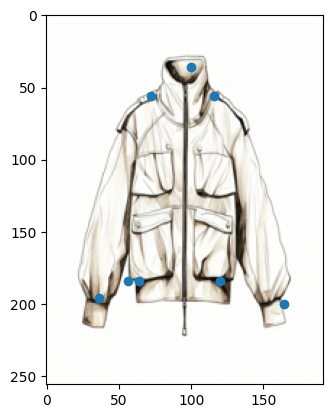

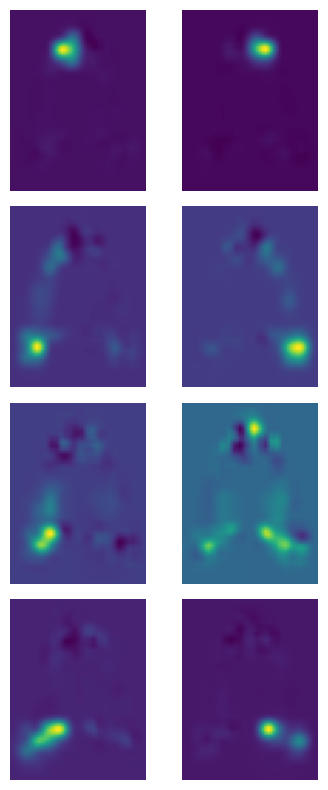

In [38]:
image = Image.open('/Users/johncao/Documents/Programming/Stanford/CS224G/finetune/utils/test_imgs/jacket.png')
def normalize_image(image: Image.Image):
    """
    Normalizes a PIL image using the given mean and standard deviation.
    
    Args:
        image (PIL.Image.Image): The input image.
    
    Returns:
        np.ndarray: The normalized image as a NumPy array.
    """
    # Convert image to NumPy array (scale to [0,1])
    image_array = np.array(image).astype(np.float32) / 255.0

    # Define mean and standard deviation
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Normalize (broadcasting across channels)
    normalized_image = (image_array - mean) / std

    return normalized_image

def extract_keypoints_from_heatmap(heatmap):
    """
    Extracts keypoint coordinates from predicted heatmaps.

    Args:
        heatmap: Tensor of shape (N_k, H, W)

    Returns:
        keypoints: List of (x, y) keypoints
    """
    N_k, H, W = heatmap.shape
    keypoints = []
    for i in range(N_k):
        # Get index of max value in heatmap
        idx = torch.argmax(heatmap[i])
        y, x = divmod(idx.item(), W)  # Convert to (y, x) coordinates
        keypoints.append((x, y))

    return keypoints

normalized_image = normalize_image(image.resize([192,256]))
x = torch.tensor(normalized_image).permute(2,0,1).unsqueeze(0).float()
with torch.no_grad():
    out = model(x)
kpts = extract_keypoints_from_heatmap(out['heatmaps'][0])
kpts_list = []
for kp in kpts:
    kpts_list.append([kp[0], kp[1]])

kpts = np.array(kpts_list)*4

fig = plt.figure()
plt.imshow(normalized_image*STD + MEAN)
plt.scatter(x=kpts[:,0], y=kpts[:,1])
plt.show()

N, H, W = out['heatmaps'][0].shape

# Determine grid size (for example, a square-ish grid)
cols = int(math.sqrt(N))
rows = math.ceil(N / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()  # make it easier to iterate

for i, ax in enumerate(axes):
    if i < N:
        ax.imshow(out['heatmaps'][0][i])  # use cmap='gray' for grayscale images
    ax.axis('off')  # hide the axes

plt.tight_layout()
plt.show()


In [35]:
out['heatmaps'][0][0].shape

torch.Size([64, 48])